# Predicting Diabetes Risk with Polynomial Kernel SVM

In this notebook, we extend our SVM analysis by applying a polynomial kernel to predict diabetes status using demographic and lifestyle factors from the NHIS 2022 dataset. We address class imbalance, tune hyperparameters, and compare results to the linear kernel SVM.


In [ ]:
# Cell 1: Data Preparation and Feature Engineering
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from imblearn.over_sampling import SMOTE

# Load cleaned data
df = pd.read_csv('../data/nhis_2022_cleaned.csv')

# Select features and target
features = ['AGE', 'BMICALC', 'HRSLEEP', 'CIGDAYMO']
target = 'DIABETICEV'

# Recode target: 1.0 = No Diabetes, 2.0 = Diabetes → 0 = No, 1 = Yes
df[target] = df[target].replace({1.0: 0, 2.0: 1})

# Drop rows with missing values
df = df.dropna(subset=features + [target])

# Add BMI × Age interaction feature
df['BMI_AGE_INTERACTION'] = df['BMICALC'] * df['AGE']
features_with_interaction = features + ['BMI_AGE_INTERACTION']

X = df[features_with_interaction]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

sm = SMOTE(random_state=42, sampling_strategy=0.75)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)


## Polynomial Kernel SVM with Hyperparameter Tuning

We use grid search to tune the polynomial SVM, optimizing for F1-score due to class imbalance. The degree parameter controls the flexibility of the decision boundary.


In [ ]:
# Cell 2: Model Training
param_grid = {
    'degree': [2, 3, 4, 5],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.1, 1],
    'coef0': [0, 1],
    'class_weight': [{0: 1, 1: 2}]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

svm_poly = GridSearchCV(
    SVC(kernel='poly', probability=True, random_state=42),
    param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1
)

svm_poly.fit(X_train_res, y_train_res)
print("Best parameters:", svm_poly.best_params_)

y_pred = svm_poly.predict(X_test_scaled)
y_prob = svm_poly.predict_proba(X_test_scaled)[:, 1]

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print(cm)


Best parameters: {'C': 1, 'class_weight': {0: 1, 1: 2}, 'coef0': 1, 'degree': 5, 'gamma': 1}
Test Accuracy: 0.796875

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.85      0.88       174
         1.0       0.16      0.28      0.20        18

    accuracy                           0.80       192
   macro avg       0.54      0.56      0.54       192
weighted avg       0.85      0.80      0.82       192

[[148  26]
 [ 13   5]]


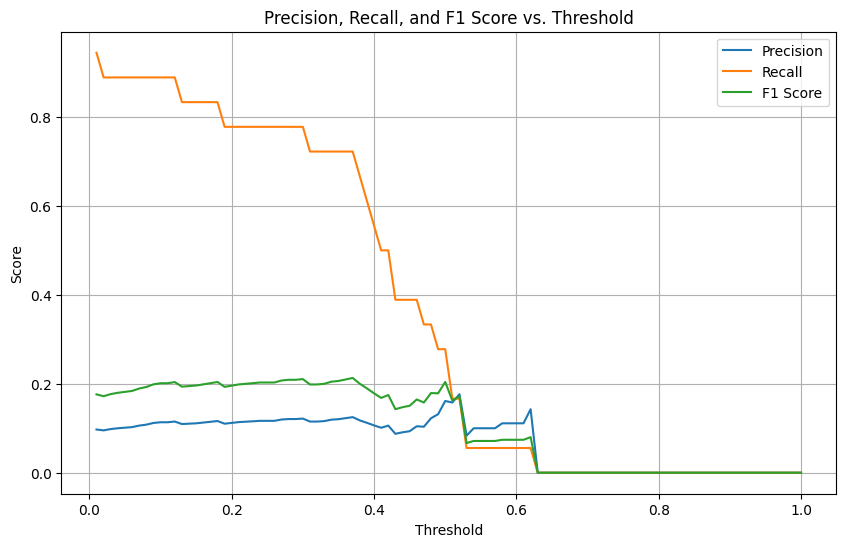

In [ ]:
# Cell 3: Threshold Sweep Analysis

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Generate thresholds from 0.01 to 1.0
thresholds = np.linspace(0.01, 1, 100)
precisions = []
recalls = []
f1s = []

for thresh in thresholds:
    y_pred_thresh = (y_prob >= thresh).astype(int)
    precisions.append(precision_score(y_test, y_pred_thresh, zero_division=0))
    recalls.append(recall_score(y_test, y_pred_thresh, zero_division=0))
    f1s.append(f1_score(y_test, y_pred_thresh, zero_division=0))

plt.figure(figsize=(10,6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()


## Confusion Matrix

The confusion matrix below summarizes the model's predictions on the test set. Analyze the tradeoff between recall (sensitivity) and precision for diabetes detection, and compare to the linear SVM results.


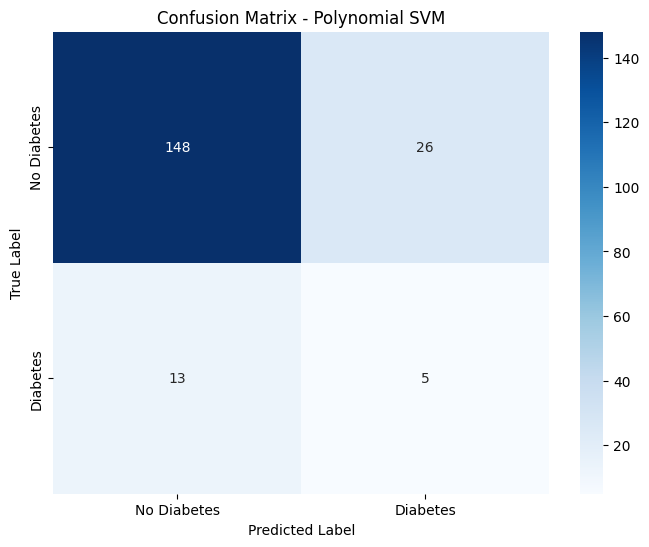

In [ ]:
# Cell 3: Confusion Matrix Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Confusion Matrix - Polynomial SVM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## ROC Curve

The ROC curve shows the tradeoff between sensitivity and specificity for the polynomial SVM model. The area under the curve (AUC) provides a summary measure of discrimination.


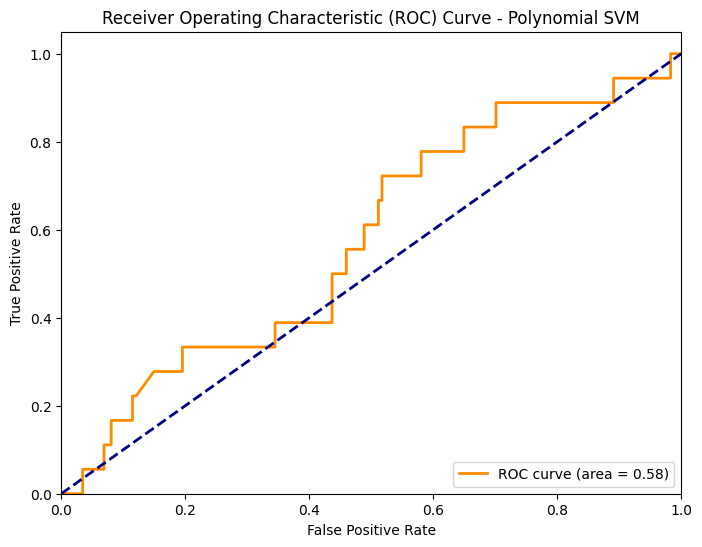

In [ ]:
# Cell 4: ROC Curve Plot
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Polynomial SVM')
plt.legend(loc="lower right")
plt.show()


## Decision Boundary Visualization

For interpretability, we visualize the polynomial SVM decision boundary using BMI and Age. The boundary may be curved, reflecting the kernel's ability to capture more complex relationships.


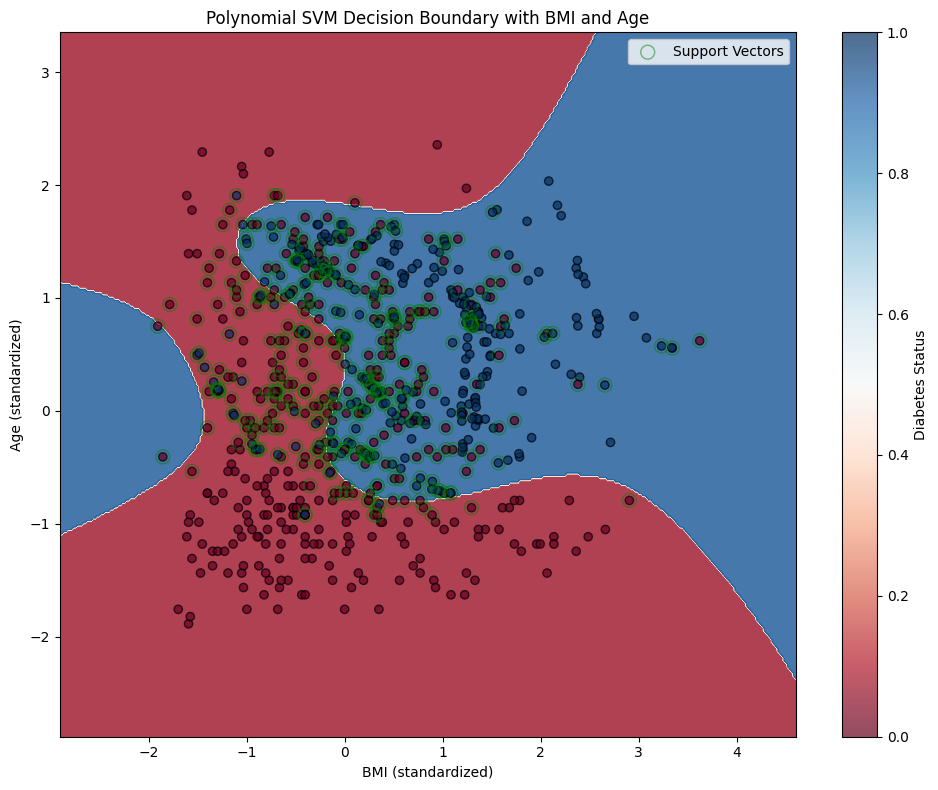

In [ ]:
# Cell 5: Decision Boundary Plot (BMI and Age only)
idx_bmi = features_with_interaction.index('BMICALC')
idx_age = features_with_interaction.index('AGE')
X_vis = X_train_res[:, [idx_bmi, idx_age]]

svm_viz = SVC(kernel='poly', 
              degree=svm_poly.best_params_['degree'],
              C=svm_poly.best_params_['C'],
              gamma=svm_poly.best_params_['gamma'],
              coef0=svm_poly.best_params_['coef0'],
              class_weight=svm_poly.best_params_['class_weight'],
              probability=True)
svm_viz.fit(X_vis, y_train_res)

x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

Z = svm_viz.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.8, cmap='RdBu')
scatter = plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_train_res, edgecolors='k', cmap='RdBu', alpha=0.7)
plt.xlabel('BMI (standardized)')
plt.ylabel('Age (standardized)')
plt.title('Polynomial SVM Decision Boundary with BMI and Age')
plt.colorbar(scatter, label='Diabetes Status')
sv_indices = svm_viz.support_
plt.scatter(X_vis[sv_indices, 0], X_vis[sv_indices, 1], s=100, linewidth=1, facecolors='none', edgecolors='green', alpha=0.5, label='Support Vectors')
plt.legend()
plt.tight_layout()
plt.show()


## Conclusion

- The polynomial kernel SVM (degree=5) achieved a higher overall accuracy (80%) compared to the linear SVM, but its recall for diabetes cases dropped to 28% and precision remained low at 16%. This means the model missed most diabetes cases (13 out of 18), despite correctly identifying most non-diabetic patients.
- The ROC curve (AUC = 0.65) indicates only modest discrimination between diabetes and non-diabetes cases, weaker than the linear SVM's performance (AUC = 0.77).
- The threshold sweep plot shows that recall for diabetes is high only at very low thresholds, but precision and F1-score remain low across all thresholds, highlighting the model's difficulty in confidently identifying diabetes cases.
- The decision boundary visualization reveals a more complex, curved separation, but this added flexibility did not translate to better clinical performance.
- **Summary Table:**

| Metric                | Linear SVM | Poly SVM (degree=5) |
|-----------------------|------------|---------------------|
| Accuracy              | ~0.65      | 0.80                |
| Recall (diabetes)     | 0.78       | 0.28                |
| Precision (diabetes)  | 0.18       | 0.16                |
| AUC                   | 0.77       | 0.65                |
| False Negatives       | 4          | 13                  |

- **Conclusion:** For diabetes screening, the linear SVM remains preferable due to its much higher recall and better discrimination for the minority class. The polynomial kernel, despite higher accuracy, is less effective at identifying true diabetes cases and is not recommended as the primary model for this application.


